In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazon-fine-food-reviews/database.sqlite


## Importing dependencies

In [3]:
import sklearn 
import tensorflow as tf
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

2025-09-22 12:59:39.300381: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758545979.647734      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758545979.742047      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## EDA

In [4]:
df = pd.read_csv("/kaggle/input/amazon-fine-food-reviews/Reviews.csv")
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [6]:
df["Score"].value_counts()

Score
5    363122
4     80655
1     52268
3     42640
2     29769
Name: count, dtype: int64

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


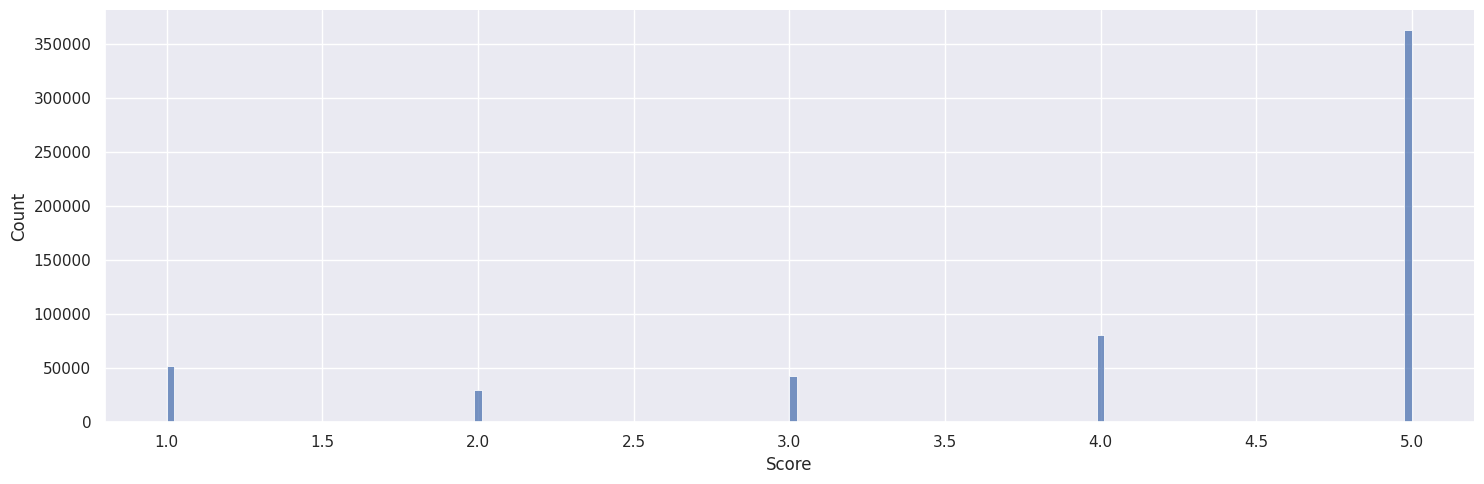

In [7]:
sns.set_theme()
sns.displot(data=df, x="Score", aspect=3)

## Cleaning and Pre-Processing

In [8]:
# Making a column called sentiment which can be used as labels.

def sort_score(x):
    if x >= 4:
        return "positive"
    elif x <= 2:
        return "negative"
    else:
        return "neutral"


df["Sentiment"] = df["Score"].apply(sort_score)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,negative
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,positive
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,negative
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,positive


In [9]:
# Pre-Preprocessing the "Text" Column

import re # Import the regular expression module
import pandas as pd # Import pandas
from nltk.corpus import stopwords # Import stopwords from NLTK

# --- One-Time Setup for NLTK ---
# You only need to run this download command once per machine.
# import nltk
# nltk.download('stopwords')
# ---------------------------------

# 1. Create a set of English stopwords for faster processing
# Using a set provides a significant speed advantage (O(1) average lookup time)
# compared to a list (O(n) lookup time).
stop_words = set(stopwords.words('english'))

def clean_text(text):
    """
    Applies a series of cleaning steps to a given text.
    
    1. Converts text to lowercase.
    2. Removes all punctuation and numbers.
    3. Removes stopwords.
    """
    # 2. Convert text to lowercase
    text = text.lower()
    
    # 3. Remove punctuation and numbers
    # Using regex to keep only alphabetic characters and spaces
    text = re.sub(r'[^a-z\s]', '', text)
    
    # 4. Remove stopwords
    # Tokenize the text (split into words) and filter out stopwords
    words = text.split()
    cleaned_words = [word for word in words if word not in stop_words]
    
    # 5. Join the words back into a single string
    return " ".join(cleaned_words)

# --- Applying the function to your DataFrame ---

# Assume 'df' is your DataFrame and it has a column named 'Text'.
# For safety, ensure the 'Text' column is of string type to avoid errors.
df['Text'] = df['Text'].astype(str)

# 6. Apply the cleaning function to the 'Text' column
# This creates a new 'cleaned_text' column with the processed text.
print("Starting text cleaning...")
df['pro_text'] = df['Text'].apply(clean_text)
print("Text cleaning complete.")

# Display the original and cleaned text for a few rows to verify
print(df[['Text', 'pro_text']].head())

Starting text cleaning...
Text cleaning complete.
                                                Text  \
0  I have bought several of the Vitality canned d...   
1  Product arrived labeled as Jumbo Salted Peanut...   
2  This is a confection that has been around a fe...   
3  If you are looking for the secret ingredient i...   
4  Great taffy at a great price.  There was a wid...   

                                            pro_text  
0  bought several vitality canned dog food produc...  
1  product arrived labeled jumbo salted peanutsth...  
2  confection around centuries light pillowy citr...  
3  looking secret ingredient robitussin believe f...  
4  great taffy great price wide assortment yummy ...  


## Tokenization and padding

In [10]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

label_mapping = {'negative':0, 'neutral':1, 'positive':2}
df['Sentiment_encoded'] = df['Sentiment'].map(label_mapping)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment,pro_text,Sentiment_encoded
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,positive,bought several vitality canned dog food produc...,2
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,negative,product arrived labeled jumbo salted peanutsth...,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,positive,confection around centuries light pillowy citr...,2
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,negative,looking secret ingredient robitussin believe f...,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,positive,great taffy great price wide assortment yummy ...,2


In [11]:
# Splitting train and test set

X = df['pro_text']
y = df['Sentiment_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    random_state=42,
    test_size=0.2,
    stratify=y
)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print("-" * 30)

Training data shape: (454763,)
Testing data shape: (113691,)
------------------------------


In [12]:
# Tokenize

VOCAB_SIZE = 20000
OOV_TOKEN = "<OOV>"

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)

# IMPORTANT: Fit the tokenizer ONLY on the training data.
print("Fitting tokenizer on training data...")
tokenizer.fit_on_texts(X_train)
print("Tokenizer fitting complete.")

Fitting tokenizer on training data...
Tokenizer fitting complete.


In [13]:
# Get the learned word index (word -> integer mapping)
word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens.")

Found 199058 unique tokens.


In [14]:
# Convert the text data into sequences of integers
print("Converting texts to sequences...")
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)
print("Sequence conversion complete.")
print("-" * 30)

Converting texts to sequences...
Sequence conversion complete.
------------------------------


Analyzing sequence lengths:
Max length: 1953
Min length: 0
Median length: 28.0


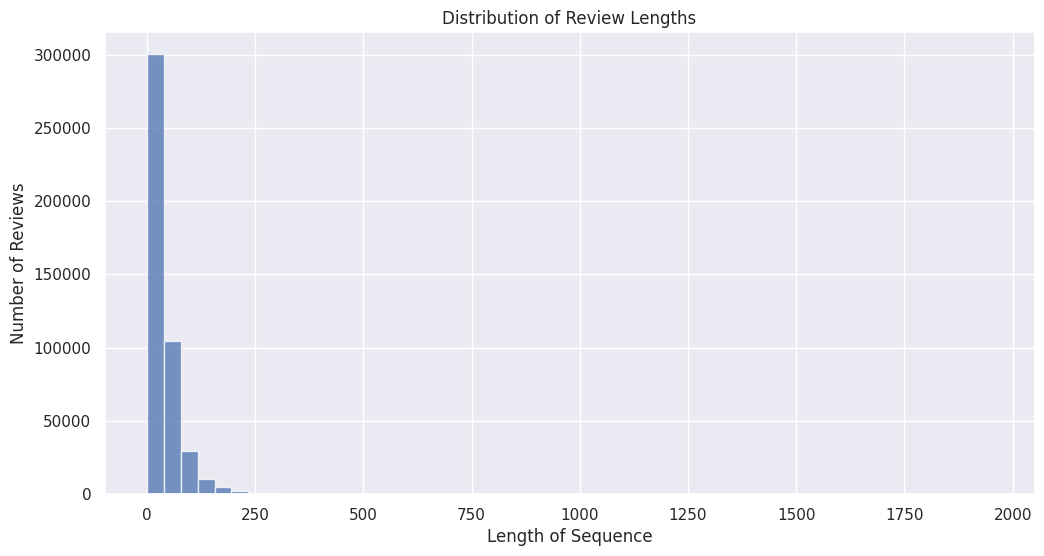

In [15]:
# --- 3. Padding ---

# A) Analyze sequence lengths to choose a good maxlen
sequence_lengths = [len(seq) for seq in X_train_sequences]

print("Analyzing sequence lengths:")
print(f"Max length: {max(sequence_lengths)}")
print(f"Min length: {min(sequence_lengths)}")
print(f"Median length: {np.median(sequence_lengths)}")

# It's highly recommended to visualize the distribution
plt.figure(figsize=(12, 6))
plt.hist(sequence_lengths, bins=50, alpha=0.75)
plt.title('Distribution of Review Lengths')
plt.xlabel('Length of Sequence')
plt.ylabel('Number of Reviews')
plt.show()

In [16]:
# Find all rows where the cleaned_text column is an empty string
empty_cleaned_reviews = df[df['pro_text'] == '']

# Display the ORIGINAL 'Text' for some of these rows
print(f"Found {len(empty_cleaned_reviews)} reviews that became empty after cleaning.")
print("\nShowing the original text for the first 10 of them:")

# Use .values to print them nicely
for text in empty_cleaned_reviews['Text'].head(10).values:
    print(f"- {text}")

Found 1 reviews that became empty after cleaning.

Showing the original text for the first 10 of them:
- &#1056;&#1077;&#1096;&#1080;&#1083;&#1072; &#1079;&#1072;&#1082;&#1072;&#1079;&#1072;&#1090;&#1100; &#1101;&#1090;&#1080; &#1078;&#1077;&#1083;&#1072;&#1090;&#1080;&#1085;&#1082;&#1080;, &#1090;.&#1082;. &#1076;&#1086;&#1095;&#1082;&#1072; &#1087;&#1086;&#1096;&#1083;&#1072; &#1074; &#1096;&#1082;&#1086;&#1083;&#1091; &#1080; &#1090;&#1088;&#1077;&#1073;&#1091;&#1077;&#1090; &#1089;&#1083;&#1072;&#1076;&#1086;&#1089;&#1090;&#1080;. &#1054;&#1095;&#1077;&#1085;&#1100; &#1091;&#1076;&#1086;&#1073;&#1085;&#1072;&#1103; &#1091;&#1087;&#1072;&#1082;&#1086;&#1074;&#1082;&#1072;. &#1050;&#1072;&#1082; &#1088;&#1072;&#1079; &#1089;&#1090;&#1086;&#1083;&#1100;&#1082;&#1086; &#1082;&#1086;&#1085;&#1092;&#1077;&#1090;, &#1082;&#1072;&#1082; &#1080; &#1090;&#1088;&#1077;&#1073;&#1091;&#1077;&#1090;&#1089;&#1103;, &#1095;&#1090;&#1086;&#1073;&#1099; &#1089;&#1100;&#1077;&#1089;&#1090;&#1100; &#1

In [17]:
import numpy as np

# Assuming 'sequence_lengths' is the list of lengths from the previous step
percentile_95 = np.percentile(sequence_lengths, 95)
print(f"95% of reviews have a length of {int(percentile_95)} or less.")

95% of reviews have a length of 112 or less.


In [18]:
# B) Pad the sequences
MAX_LEN = 120 # A reasonable choice based on typical review lengths.
              # Adjust this after viewing the histogram. You want a value
              # that captures the majority of reviews without being too long.

print(f"Padding sequences to max length of {MAX_LEN}...")
X_train_padded = pad_sequences(
    X_train_sequences, 
    maxlen=MAX_LEN, 
    padding='post',    # Add padding to the end of the sequence
    truncating='post'  # Truncate sequences longer than maxlen from the end
)

X_test_padded = pad_sequences(
    X_test_sequences, 
    maxlen=MAX_LEN, 
    padding='post', 
    truncating='post'
)
print("Padding complete.")
print("-" * 30)

Padding sequences to max length of 120...
Padding complete.
------------------------------


In [19]:
# --- 4. Final Verification ---

# The data is now ready for the model. Let's check the final shapes.
# The 'X' variables should be 2D tensors (num_samples, max_len)
# The 'y' variables should be 1D tensors (num_samples,)
print("Final data shapes:")
print(f"X_train_padded shape: {X_train_padded.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test_padded shape: {X_test_padded.shape}")
print(f"y_test shape: {y_test.shape}")

# Let's see an example of what happened to a single review
print("\n--- Example Transformation ---")
sample_index = 0
print(f"Original Text:\n{X_train.iloc[sample_index]}")
print(f"\nAfter Tokenization (first 20 tokens):\n{X_train_sequences[sample_index][:20]}...")
print(f"\nAfter Padding:\n{X_train_padded[sample_index]}")

Final data shapes:
X_train_padded shape: (454763, 120)
y_train shape: (454763,)
X_test_padded shape: (113691, 120)
y_test shape: (113691,)

--- Example Transformation ---
Original Text:
like good fiber plenty protein good price thing consistency fine sand dont taste anything girlfreind says tastes like bad breath think works best smoothies mix water sometimes literally sinks bottom glass mix every sip end green wet sand bottom cup done best blended

After Tokenization (first 20 tokens):
[3, 4, 427, 923, 195, 4, 29, 140, 695, 287, 4932, 17, 6, 183, 1, 389, 56, 3, 118, 1114]...

After Padding:
[    3     4   427   923   195     4    29   140   695   287  4932    17
     6   183     1   389    56     3   118  1114    50   305    27  1514
    77    40   366  1211 12435   578   609    77    75  1304   404   125
   752  4932   578    45   566    27  2124     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0

## Buliding the model Architecture

In [20]:
from tensorflow import keras
from tensorflow.keras.models import Sequential


model = keras.Sequential()

model.add(keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=128, input_length=MAX_LEN))
model.add(keras.layers.LSTM(units=64, dropout=0.2))
model.add(keras.layers.Dense(units=3, activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1758546042.759833      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758546042.760611      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Training and Judging model

In [21]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 5
BATCH_SIZE = 64

history = model.fit(
    X_train_padded,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test_padded, y_test)
)

print("Training Complete!")

Epoch 1/5


I0000 00:00:1758546048.239833      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


7106/7106 ━━━━━━━━━━━━━━━━━━━━ 70s 9ms/step - accuracy: 0.7848 - loss: 0.6538 - val_accuracy: 0.8504 - val_loss: 0.4209
Epoch 2/5
7106/7106 ━━━━━━━━━━━━━━━━━━━━ 64s 9ms/step - accuracy: 0.8641 - loss: 0.3802 - val_accuracy: 0.8805 - val_loss: 0.3255
Epoch 3/5
7106/7106 ━━━━━━━━━━━━━━━━━━━━ 64s 9ms/step - accuracy: 0.8964 - loss: 0.2850 - val_accuracy: 0.8916 - val_loss: 0.3069
Epoch 4/5
7106/7106 ━━━━━━━━━━━━━━━━━━━━ 64s 9ms/step - accuracy: 0.9160 - loss: 0.2365 - val_accuracy: 0.8954 - val_loss: 0.3026
Epoch 5/5
7106/7106 ━━━━━━━━━━━━━━━━━━━━ 64s 9ms/step - accuracy: 0.9309 - loss: 0.1966 - val_accuracy: 0.8977 - val_loss: 0.3046
Training Complete!


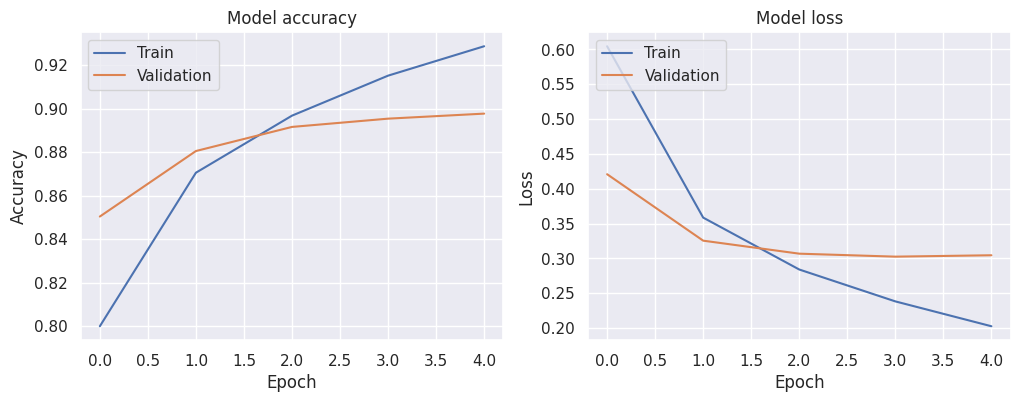

In [22]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.show()

plot_history(history)

3553/3553 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.8977 - loss: 0.3055

Test Accuracy: 89.72%
Test Loss: 0.3048
3553/3553 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step

Classification Report:
              precision    recall  f1-score   support

    negative       0.80      0.77      0.78     16407
     neutral       0.59      0.46      0.52      8528
    positive       0.94      0.96      0.95     88756

    accuracy                           0.90    113691
   macro avg       0.78      0.73      0.75    113691
weighted avg       0.89      0.90      0.89    113691


Confusion Matrix:


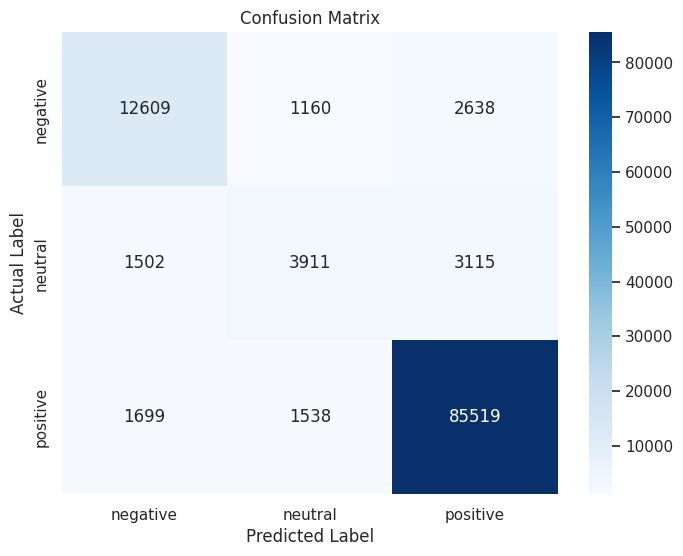

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# 1. Get final loss and accuracy on the test set
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f"\nTest Accuracy: {accuracy*100:.2f}%")
print(f"Test Loss: {loss:.4f}")

# 2. Get model predictions
# .predict() returns probabilities for each class
y_pred_probs = model.predict(X_test_padded)
# We take the index of the highest probability as our final prediction
y_pred = np.argmax(y_pred_probs, axis=1)

# 3. Generate a Classification Report
# This shows precision, recall, and f1-score for each class.
print("\nClassification Report:")
# We need the actual label names for the report
class_labels = ['negative', 'neutral', 'positive']
print(classification_report(y_test, y_pred, target_names=class_labels))

# 4. Generate and plot a Confusion Matrix
# This shows where the model is getting confused.
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()